In [28]:
from scipy.io import loadmat, savemat
import torch
import matplotlib.pyplot as plt
import pickle

%load_ext autoreload
%autoreload 2
%matplotlib inline

from dstft import DSTFT, FDSTFT, entropy_loss, fast_sst, frequency_tracking

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1802);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# specs = {} 
# stfts = {}
# wins = {}
# losses = {} 
# f_hats = {} 
# ss = {} 
# losses2 = {} 
# f_hats2 = {} 

# with open("../fig/4_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/4_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/4_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/4_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/4_f_hats.pkl", "wb") as file: pickle.dump(f_hats, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/4_ss.pkl", "wb") as file: pickle.dump(ss, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/4_losses2.pkl", "wb") as file: pickle.dump(losses2, file, pickle.HIGHEST_PROTOCOL)
# with open("../fig/4_f_hats2.pkl", "wb") as file: pickle.dump(f_hats2, file, pickle.HIGHEST_PROTOCOL)

In [30]:
mat = loadmat('../data/x_vitesse2.mat')['xt']
x = torch.from_numpy(mat).float().to(device)[:, 38_000:60_000]
stride = 50; support = 1_500

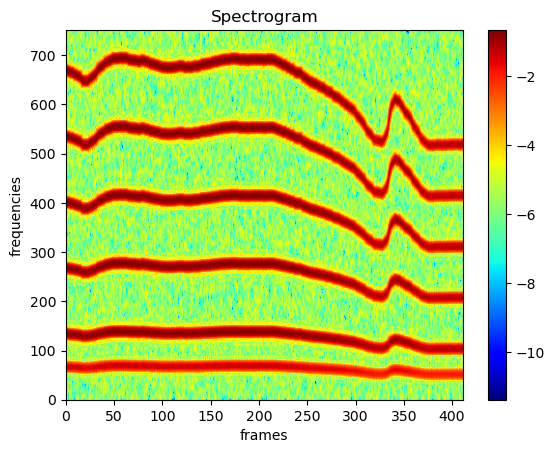

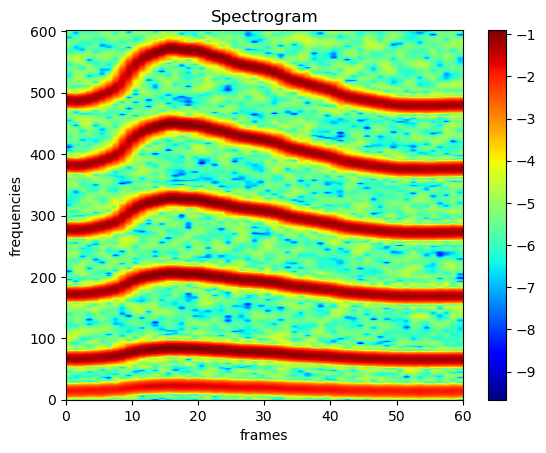

In [31]:
dstft = FDSTFT(x, win_length=200, support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft, *_ = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)
dstft.print(spec[:, 38:640, 325:385], x, bar=True, wins=False, weights=False) 

with open("../fig/4_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['200'] = spec.detach().cpu()
with open("../fig/4_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/4_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['200'] = stft.detach().cpu()
with open("../fig/4_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/4_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['200'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/4_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/4_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['200'] = entropy_loss(spec).cpu()
with open("../fig/4_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

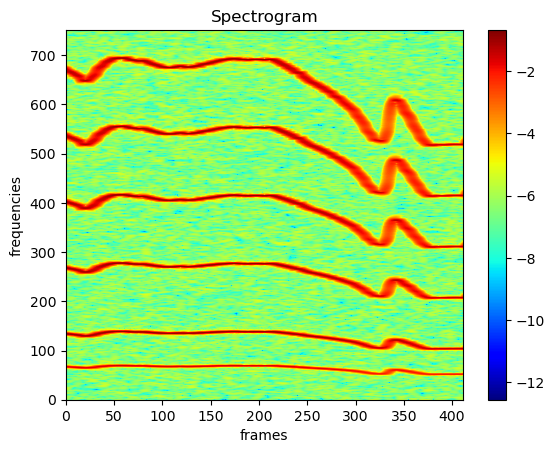

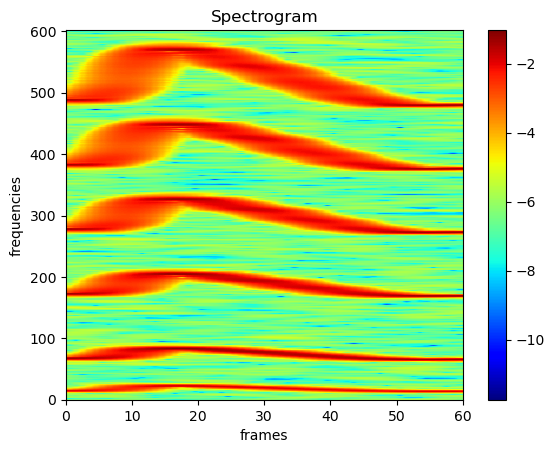

In [32]:
dstft = FDSTFT(x, win_length=1_000, support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
spec, stft, real, imag, phase = dstft(x)
dstft.print(spec, weights=False, wins=False, bar=True)
dstft.print(spec[:, 38:640, 325:385], x, bar=True, wins=False, weights=False) 

with open("../fig/4_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['1000'] = spec.detach().cpu()
with open("../fig/4_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/4_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['1000'] = stft.detach().cpu()
with open("../fig/4_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/4_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['1000'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/4_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/4_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['1000'] = entropy_loss(spec).cpu()
with open("../fig/4_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

Single window length

Epoch 00102: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00202: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00302: reducing learning rate of group 0 to 1.0000e-01.
301 792.9


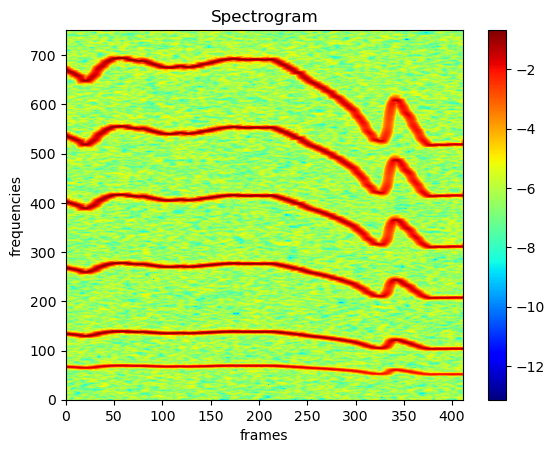

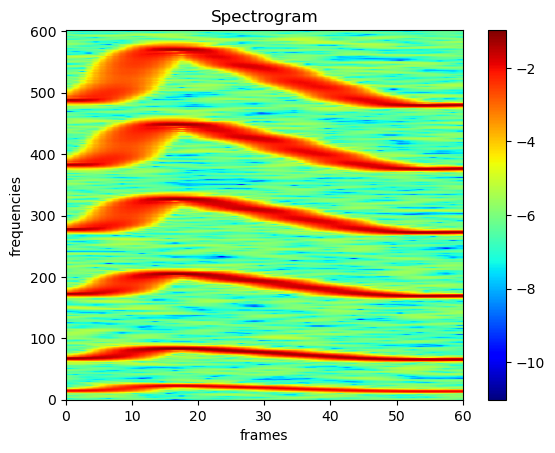

In [33]:
dstft = FDSTFT(x, win_length=877, support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p=None, stride_p=None)
params = [{'params': dstft.win_length,    'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

min_err = 100
min_win = 0

for epoch in range(1_000):
    opt.zero_grad()    
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()    
    opt.step()
    sch.step(err)
    
    if err < min_err:
        min_err = err
        min_win = dstft.win_length.item()
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch, f'{dstft.win_length.item():.1f}')
dstft.print(spec, x, bar=True, wins=False, weights=False)
dstft.print(spec[:, 38:640, 325:385], x, bar=True, wins=False, weights=False)

with open("../fig/4_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['single'] = spec.detach().cpu()
with open("../fig/4_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/4_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['single'] = stft.detach().cpu()
with open("../fig/4_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/4_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['single'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/4_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/4_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['single'] = entropy_loss(spec).detach().cpu()
with open("../fig/4_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)


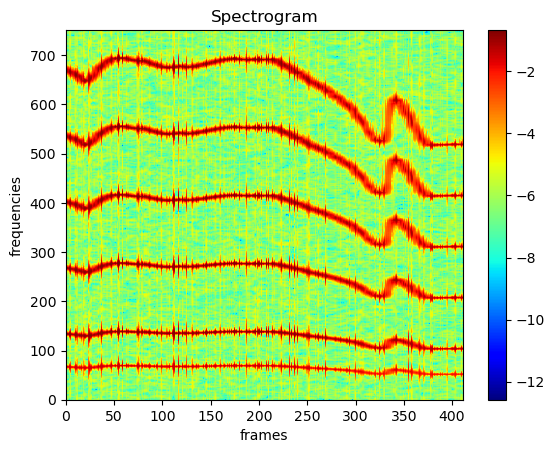

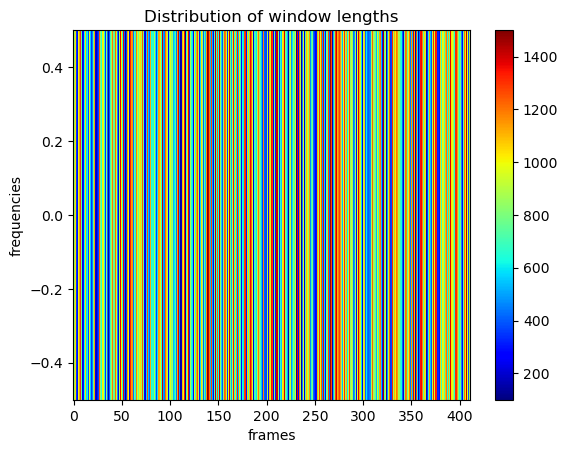

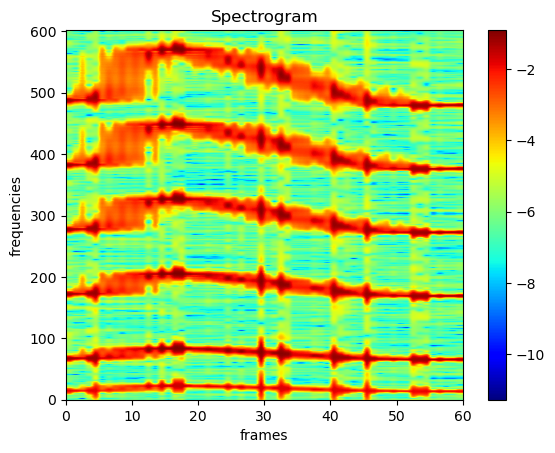

In [34]:
dstft = FDSTFT(x, win_length=877, support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
dstft.win_length.data = dstft.win_min + (dstft.win_max - dstft.win_min) * torch.rand(dstft.win_length.size(), device=device)
spec, stft, *_ = dstft(x)
dstft.print(spec, wins=False, bar=True)
dstft.print(spec[:, 38:640, 325:385], x, bar=True, wins=False, weights=False)

with open("../fig/4_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['random'] = spec.detach().cpu()
with open("../fig/4_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/4_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['random'] = stft.detach().cpu()
with open("../fig/4_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/4_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['random'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/4_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/4_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['random'] = entropy_loss(spec).detach().cpu()
with open("../fig/4_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

Time-varying window length

Epoch 00134: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00234: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00334: reducing learning rate of group 0 to 1.0000e-01.
333


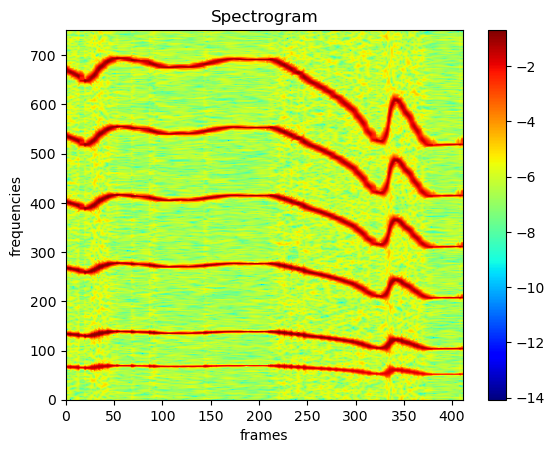

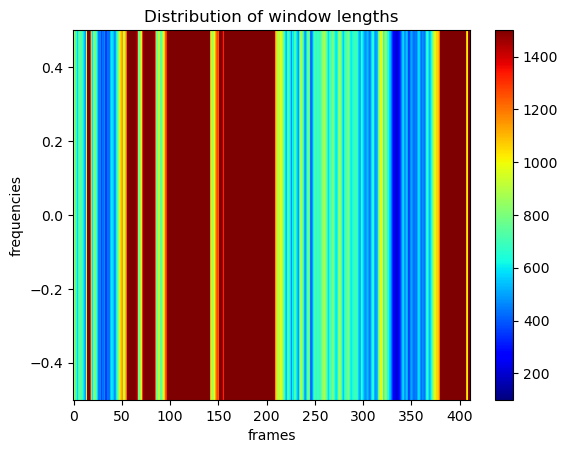

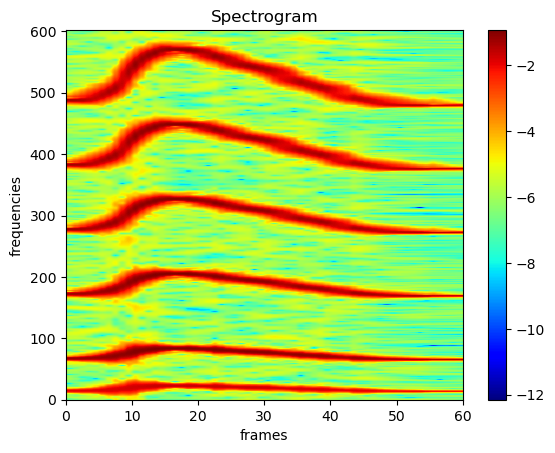

In [35]:
dstft = FDSTFT(x, win_length=577, support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break
    
print(epoch)
dstft.print(spec, x, bar=True, wins=False)
dstft.print(spec[:, 38:640, 325:385], x, bar=True, wins=False, weights=False)

with open("../fig/4_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['t'] = spec.detach().cpu()
with open("../fig/4_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/4_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['t'] = stft.detach().cpu()
with open("../fig/4_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/4_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['t'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/4_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/4_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['t'] = entropy_loss(spec).detach().cpu()
with open("../fig/4_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

Epoch 00341: reducing learning rate of group 0 to 1.0000e+01.
Epoch 00470: reducing learning rate of group 0 to 1.0000e+00.
Epoch 00574: reducing learning rate of group 0 to 1.0000e-01.
573


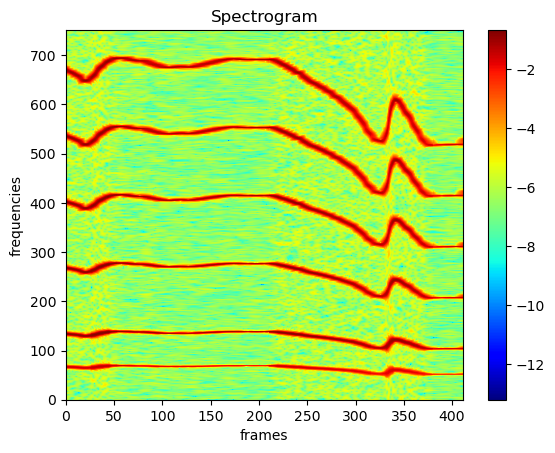

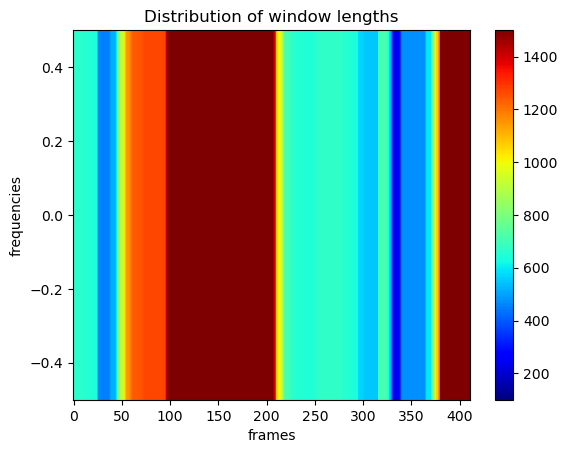

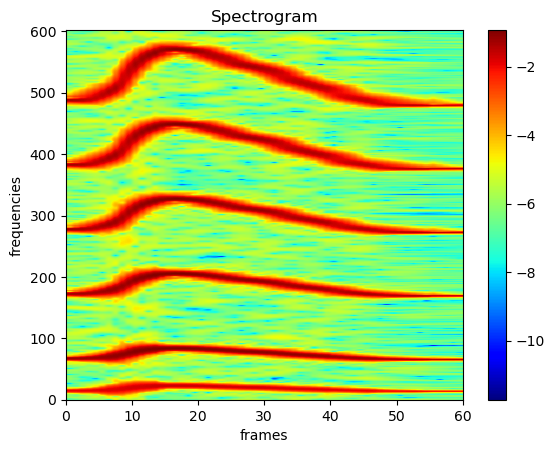

In [36]:
dstft = FDSTFT(x, win_length=577, support=support, stride=stride, win_requires_grad=True, stride_requires_grad=False, win_p='t', win_min=100)
params = [{'params': dstft.win_length, 'lr': 100.0}, ] 
opt = torch.optim.Adam(params)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode='min', factor=.1, patience=99, verbose=True)

for epoch in range(1_000):
    opt.zero_grad()    
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec) + 0.001 * (dstft.actual_win_length.diff(dim=1).pow(2) + torch.finfo(x.dtype).eps).sqrt().mean()
    err.backward()
    opt.step()
    sch.step(err)
    
    if opt.param_groups[0]['lr'] < 1:
        break

print(epoch)
dstft.print(spec, x, bar=True, wins=False)
dstft.print(spec[:, 38:640, 325:385], x, bar=True, wins=False, weights=False)

with open("../fig/4_specs.pkl", "rb") as file: specs = pickle.load(file)
specs['t2'] = spec.detach().cpu()
with open("../fig/4_specs.pkl", "wb") as file: pickle.dump(specs, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/4_stfts.pkl", "rb") as file: stfts = pickle.load(file)
stfts['t2'] = stft.detach().cpu()
with open("../fig/4_stfts.pkl", "wb") as file: pickle.dump(stfts, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/4_wins.pkl", "rb") as file: wins = pickle.load(file)
wins['t2'] = dstft.actual_win_length.mean().detach().cpu()
with open("../fig/4_wins.pkl", "wb") as file: pickle.dump(wins, file, pickle.HIGHEST_PROTOCOL)
    
with open("../fig/4_losses.pkl", "rb") as file: losses = pickle.load(file)
losses['t2'] = entropy_loss(spec).detach().cpu()
with open("../fig/4_losses.pkl", "wb") as file: pickle.dump(losses, file, pickle.HIGHEST_PROTOCOL)

792


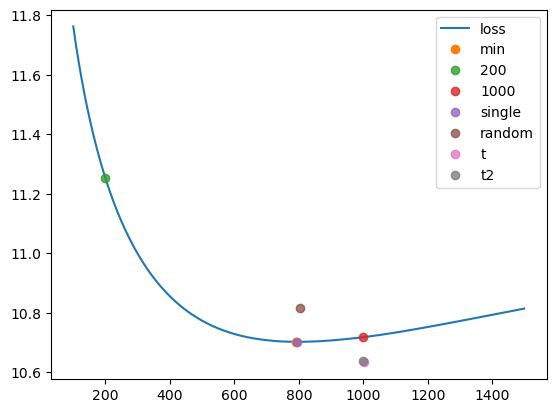

In [37]:
loss_function = []
min_err = 100
min_win = 0

for win_length in range(100, support, 1):
    dstft = FDSTFT(x, win_length=win_length, support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)
    
    if err < min_err:
        min_err = err
        min_win = win_length
    loss_function.append(err.cpu())
    
print(min_win)
plt.plot(range(100, support, 1), loss_function, label='loss')
plt.plot(min_win, min_err.cpu(), 'o', label='min')

with open("../fig/4_losses.pkl", "rb") as file: losses = pickle.load(file)
with open("../fig/4_wins.pkl", "rb") as file: wins = pickle.load(file)
for key, loss in losses.items():
    plt.plot(wins[key], loss, 'o', alpha=.8, label=key)
plt.legend()
plt.show()

In [38]:
with open("../fig/4_stfts.pkl", "rb") as file: stfts = pickle.load(file)
with open("../fig/4_ss.pkl", "rb") as file: ss = pickle.load(file)
with open("../fig/4_losses2.pkl", "rb") as file: losses2 = pickle.load(file)

for key, stft in stfts.items():
    z = fast_sst(stft[0], 10, stft.shape[-2], stft.shape[-1], .2, device)
    ss[key] = z
    losses2[key] = entropy_loss(z).detach().cpu()
    
with open("../fig/4_ss.pkl", "wb") as file: pickle.dump(ss, file, pickle.HIGHEST_PROTOCOL)
with open("../fig/4_losses2.pkl", "wb") as file: pickle.dump(losses2, file, pickle.HIGHEST_PROTOCOL)

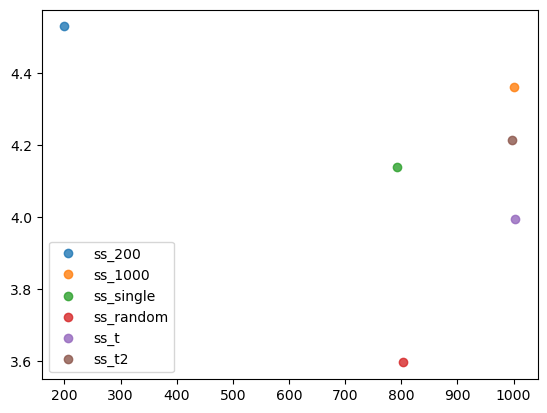

In [39]:
with open("../fig/4_losses2.pkl", "rb") as file: losses2 = pickle.load(file)
with open("../fig/4_wins.pkl", "rb") as file: wins = pickle.load(file)
for key, loss in losses2.items(): plt.plot(wins[key], loss, 'o', alpha=.8, label=f'ss_{key}')
plt.legend()
plt.show()

792


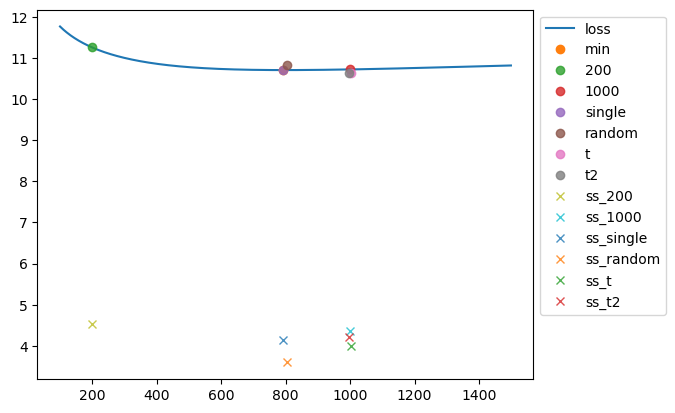

In [40]:
loss_function = []
min_err = 100
min_win = 0

for win_length in range(100, support, 1):
    dstft = FDSTFT(x, win_length=win_length, support=support, stride=stride, win_requires_grad=False, stride_requires_grad=False, win_p=None, stride_p=None)
    spec, stft, *_ = dstft(x)
    err = entropy_loss(spec)
    
    if err < min_err:
        min_err = err
        min_win = win_length
    loss_function.append(err.cpu())
    
print(min_win)
plt.plot(range(100, support, 1), loss_function, label='loss')
plt.plot(min_win, min_err.cpu(), 'o', label='min')

with open("../fig/4_losses.pkl", "rb") as file: losses = pickle.load(file)
with open("../fig/4_losses2.pkl", "rb") as file: losses2 = pickle.load(file)
with open("../fig/4_wins.pkl", "rb") as file: wins = pickle.load(file)
for key, loss in losses.items(): plt.plot(wins[key], loss, 'o', alpha=.8, label=key)
for key, loss in losses2.items(): plt.plot(wins[key], loss, 'x', alpha=.8, label=f'ss_{key}')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

200


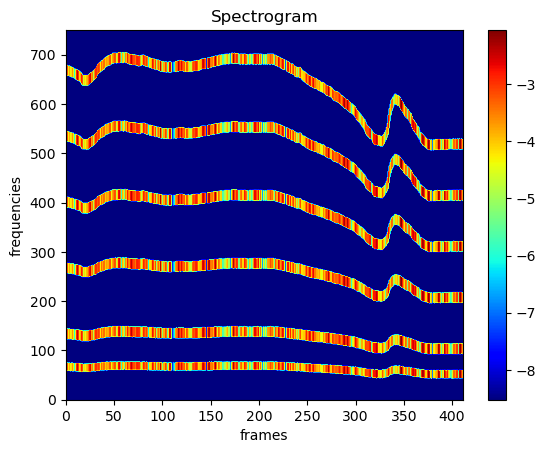

1000


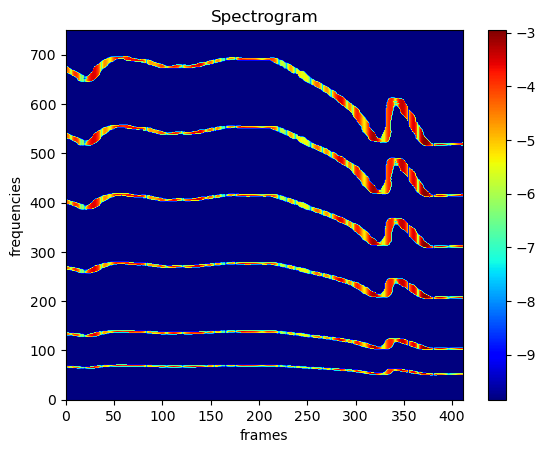

single


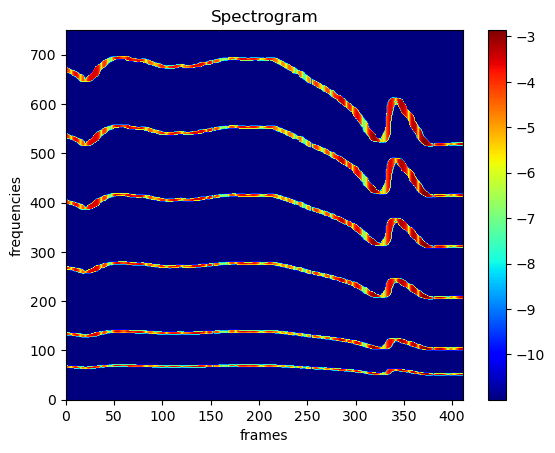

random


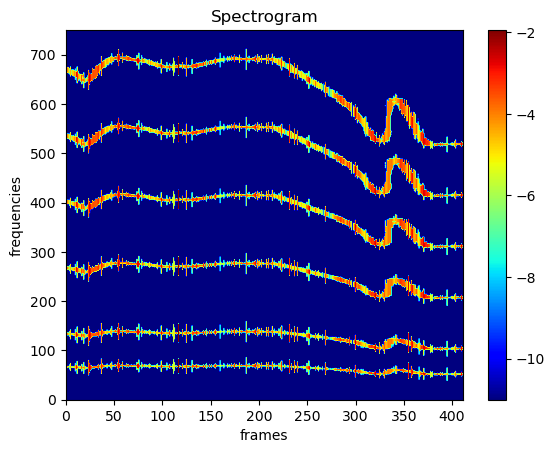

t


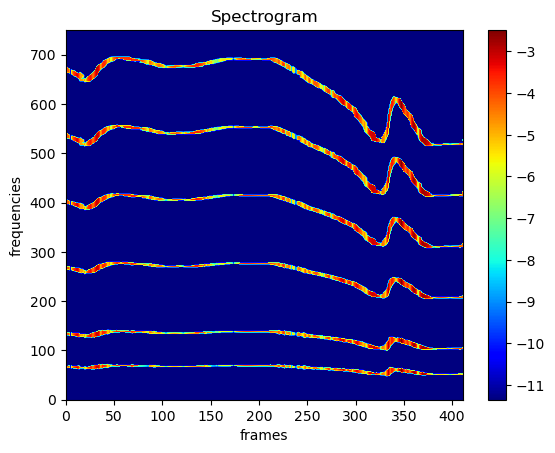

t2


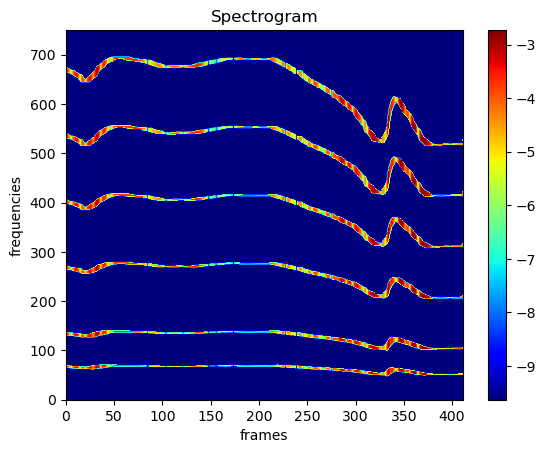

In [41]:
with open("../fig/4_ss.pkl", "rb") as file: ss = pickle.load(file)
for key, z in ss.items(): print(key); dstft.print(z[None, ...], x, bar=True, wins=False, weights=False)

200


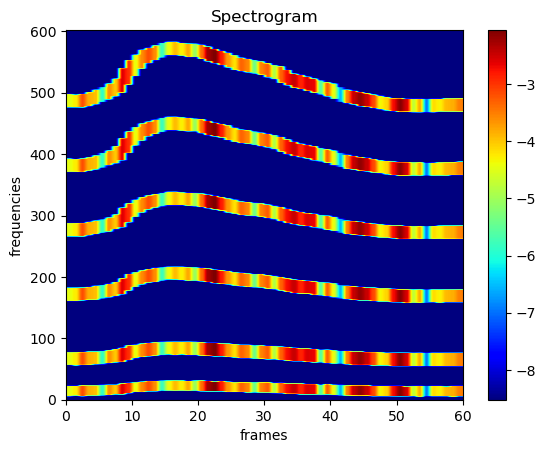

1000


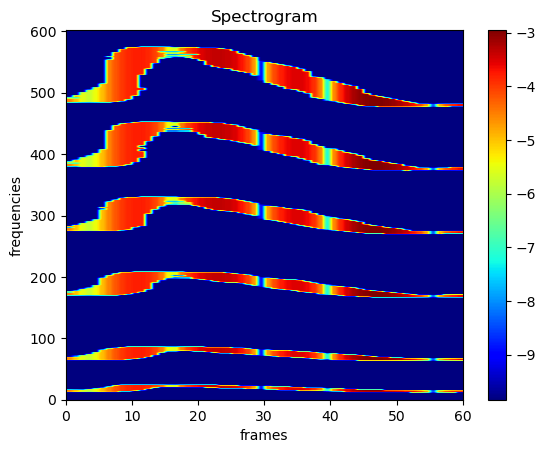

single


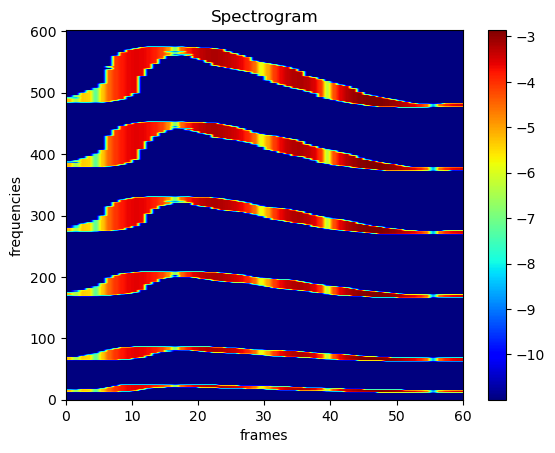

random


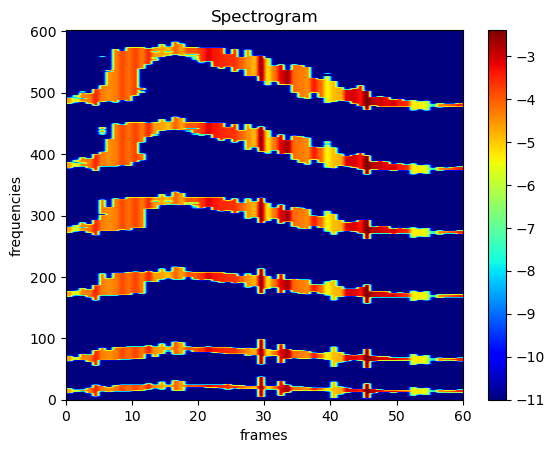

t


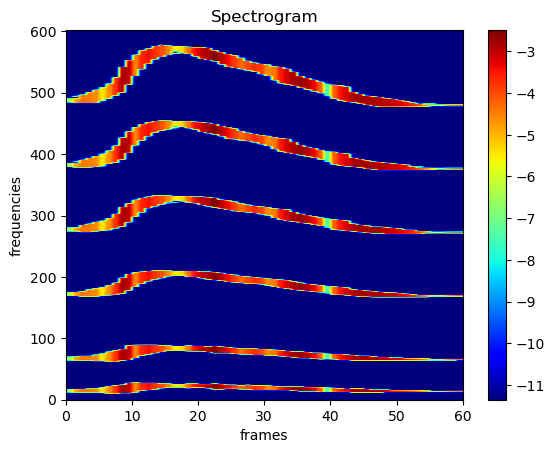

t2


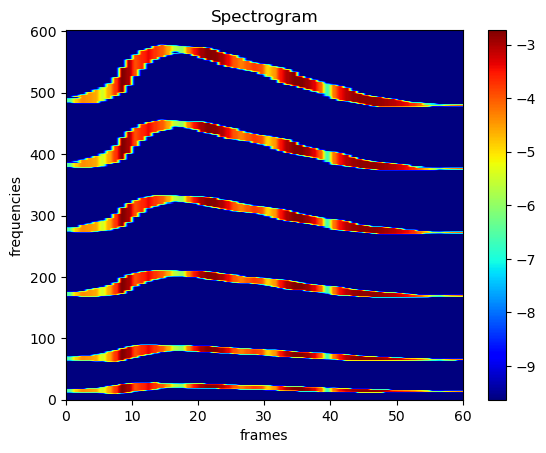

In [42]:
with open("../fig/4_ss.pkl", "rb") as file: ss = pickle.load(file)
for key, z in ss.items(): print(key); dstft.print(z[None, 38:640, 325:385], x, bar=True, wins=False, weights=False)

In [43]:
# with open("../fig/4_specs.pkl", "rb") as file: specs = pickle.load(file)
# with open("../fig/4_f_hats.pkl", "rb") as file: f_hats = pickle.load(file)
# for key, spec in specs.items():
#     f_hat, out = frequency_tracking(y=x, fs=1e4, spec=spec[0], fmin=0, fmax=.1, alpha=100, orders=[4, 8, 16])
#     f_hats[key] = out
#     # f_hat = torch.nn.functional.interpolate((out*fs/2/spec.shape[0])[None, None, None, ...], size=x[0].shape[-1], mode='bicubic').squeeze()[0]

# with open("../fig/4_f_hats.pkl", "wb") as file: pickle.dump(f_hats, file, pickle.HIGHEST_PROTOCOL)

In [44]:
# with open("../fig/4_specs.pkl", "rb") as file: specs = pickle.load(file)
# with open("../fig/4_ss.pkl", "rb") as file: ss = pickle.load(file)
# with open("../fig/4_f_hats.pkl", "rb") as file: f_hats = pickle.load(file)

# for key, out in f_hats.items(): 
#     print(key)
    
#     plt.figure()
#     plt.title(f'Spectrogram {key}')
#     ax = plt.subplot()
#     im = ax.imshow(specs[key][0].log(), aspect='auto', origin='lower', cmap='jet', extent=[0,spec.shape[-1], 0, spec.shape[-2]])
#     plt.ylabel('frequencies')
#     plt.xlabel('frames')
#     plt.colorbar(im, ax=ax)
#     plt.plot(out, 'k', alpha=.5,  linewidth=1)
#     plt.show()
    
#     plt.figure()
#     plt.title(f'Synchrosqueeze {key}')
#     ax = plt.subplot()
#     im = ax.imshow(ss[key].log(), aspect='auto', origin='lower', cmap='jet', extent=[0,spec.shape[-1], 0, spec.shape[-2]])
#     plt.ylabel('frequencies')
#     plt.xlabel('frames')
#     plt.colorbar(im, ax=ax)
#     plt.plot(out, 'k', alpha=.5,  linewidth=1)
#     plt.show()